In [1]:
from __future__ import division
import re
import urllib2
import pandas as pd
import StringIO
import zipfile
import requests
import numpy as np
import googlemaps
import pickle
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
path = 'https://s3.amazonaws.com/tripdata/'
response = urllib2.urlopen(path).read()

In [3]:
regex = re.compile('2015\d{1,2}-citibike-tripdata.zip')

In [4]:
files = regex.findall(response)

In [5]:
def zip_to_csv(zip_name):
    base_name = zip_name[:zip_name.find('.zip')]
    return base_name + '.csv'

In [6]:
csv_names = [zip_to_csv(name) for name in files]

In [7]:
def zipped_online_csv_read(url, csv_filename, **kwargs):
    s = requests.get(url).content
    z = zipfile.ZipFile(StringIO.StringIO(s))
    return pd.read_csv(z.open(csv_filename), **kwargs)

In [8]:
columns = ("start station id, end station id, "
           "start station latitude, start station longitude, "
           "end station latitude, tripduration, "
           "end station longitude, usertype").split(', ')

In [9]:
kwargs = {'usecols':columns}

In [10]:
df = pd.DataFrame(columns=columns)
counter = 0
for i in zip(files, csv_names)[:3]:
    file_path = path + i[0]
    df = df.append(zipped_online_csv_read(file_path, i[1],
                                          **kwargs))
    print(i[1])
    print(df.shape)
    counter += 1
    

201501-citibike-tripdata.csv
(285552, 8)
201502-citibike-tripdata.csv
(482482, 8)
201503-citibike-tripdata.csv
(824308, 8)


## Getting google directions data

In [11]:
west_side_hwy_stations = [72, 458, 459, 478, 508, 525, 530,
                          514]
first_ave_stations = [2012, 2003, 545, 536, 527, 516, 504, 455,
                      454, 438, 428, 326, 174]

In [12]:
with open('GoogleAPIKey.txt','r') as myfile:
    gm=googlemaps.Client(key=myfile.readlines()[0])

In [13]:
wsh_trips = (df[df['start station id']
                .isin(west_side_hwy_stations)])

In [14]:
wsh_group = wsh_trips.groupby('start station id')
wsh_lat = wsh_group['start station latitude'].unique()
wsh_lon = wsh_group['start station longitude'].unique()

In [15]:
wsh_lat_lon = np.array([wsh_lat,
                        wsh_lon]).T[0].astype(np.float64)

In [16]:
first_trips = (df[df['start station id']
               .isin(first_ave_stations)])
first_group = first_trips.groupby('start station id')
first_lat = first_group['start station latitude'].unique()
first_lon = first_group['start station longitude'].unique()
first_lat_lon = np.array([first_lat,
                          first_lon]).T[0].astype(np.float64)

In [17]:
west_side = gm.distance_matrix(wsh_lat_lon,
                               wsh_lat_lon, mode='bicycling')

In [18]:
with open('west_side.pkl', 'w') as f:
    pickle.dump(west_side, f)

In [19]:
west_side_array = np.array([[j['distance']['value']
                              for j in i['elements']]
                             for i in west_side['rows']])

west_side_time = np.array([[j['duration']['value']
                              for j in i['elements']]
                             for i in west_side['rows']])


In [20]:
west_side_df = pd.DataFrame(west_side_array,
                            index=west_side_hwy_stations,
                            columns=west_side_hwy_stations)

west_side_time = pd.DataFrame(west_side_time,
                            index=west_side_hwy_stations,
                            columns=west_side_hwy_stations)

In [21]:
cross_town = gm.distance_matrix(wsh_lat_lon,
                                first_lat_lon[:8],
                                mode='bicycling')

In [22]:
with open('cross_town.pkl', 'w') as f:
    pickle.dump(cross_town, f)

In [23]:
cross_town_array = np.array([[j['distance']['value']
                              for j in i['elements']]
                             for i in cross_town['rows']])

cross_town_time = np.array([[j['duration']['value']
                              for j in i['elements']]
                             for i in cross_town['rows']])

In [24]:
cross_town_df = pd.DataFrame(cross_town_array,
                            index=west_side_hwy_stations,
                            columns=first_ave_stations[:8])

cross_town_time = pd.DataFrame(cross_town_time,
                            index=west_side_hwy_stations,
                            columns=first_ave_stations[:8])

## Plotting time relationship

In [25]:
ct_true = pd.Series(np.ones(cross_town_time.stack().shape),
                    index=cross_town_time.stack().index)
google_data_ct = pd.concat([cross_town_df.stack(), cross_town_time.stack(), ct_true], axis=1)
ct_false = pd.Series(np.zeros(west_side_time.stack().shape),
                     index=west_side_time.stack().index)
google_data_ws = pd.concat([west_side_df.stack(), west_side_time.stack(), ct_false], axis=1)
google_data = pd.concat([google_data_ct, google_data_ws])
google_data.rename(columns={0:'distance', 1:'duration',2:'crosstown'}, inplace=True)
google_data_ct.rename(columns={0:'distance', 1:'duration',2:'crosstown'}, inplace=True)
google_data_ws.rename(columns={0:'distance', 1:'duration',2:'crosstown'}, inplace=True)


In [26]:
google_model = smf.ols(formula='duration ~ distance + crosstown + 1', data=google_data)
google_results = google_model.fit()
google_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5793.
Date:                Mon, 31 Oct 2016   Prob (F-statistic):          5.91e-124
Time:                        08:55:45   Log-Likelihood:                -684.95
No. Observations:                 128   AIC:                             1376.
Df Residuals:                     125   BIC:                             1384.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     61.7094      8.860      6.965      0.000        44.174    79.245
distance       0.1863      0.004     42.079      0.000         0.178     0.195
crosstown    296.8201     17.077     17.381      0.000       263.023   330.618
==============================================================================
Omnibus:                        4.336   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                3.774
Skew:                           0.388   Prob(JB):                        0.152
Kurtosis:                       3.326   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
with open('google_results.pkl', 'w') as f:
    pickle.dump(google_results, f)

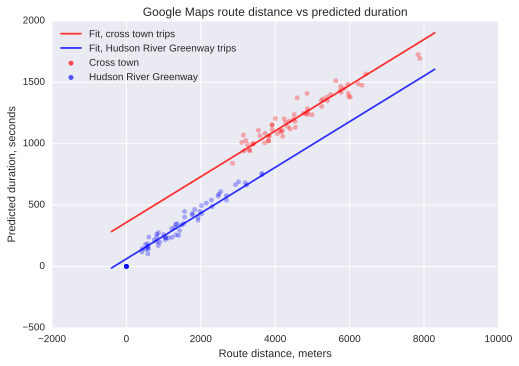

In [28]:
XX = np.arange(google_data['distance'].min() - 400, google_data['distance'].max() + 400)
gm_ctXX = pd.DataFrame({'distance':XX, 'crosstown':np.ones(XX.shape)})
gm_wsXX = pd.DataFrame({'distance':XX, 'crosstown':np.zeros(XX.shape)})
plt.scatter(google_data_ct['distance'], google_data_ct['duration'], color='r', alpha=0.3, label='Cross town')
plt.plot(gm_ctXX['distance'], google_results.predict(gm_ctXX), color='r', alpha=0.8, label='Fit, cross town trips')
plt.scatter(google_data_ws['distance'], google_data_ws['duration'], color='blue', alpha=0.3, label='Hudson River Greenway')
plt.plot(gm_wsXX['distance'], google_results.predict(gm_wsXX), color='b', alpha=0.8, label='Fit, Hudson River Greenway trips')
plt.title('Google Maps route distance vs predicted duration')
plt.xlabel('Route distance, meters')
plt.ylabel('Predicted duration, seconds')
plt.legend(loc='upper left')
plt.savefig('google_maps_trip_distance_vs_duration.pdf')
plt.show()

## Merging in google maps data

In [29]:
use_trip = ((df['start station id']
             .isin(west_side_hwy_stations))
            & (df['end station id']
              .isin(west_side_hwy_stations
                    + first_ave_stations[:8]))
            & (df['start station id']
               != df['end station id']))

In [30]:
df = df[use_trip]

In [31]:
west_trips = df[(df['start station id']
                 .isin(west_side_hwy_stations))
                & (df['end station id']
                  .isin(west_side_hwy_stations))]
def distance_lookup(ser, table):
    return table.loc[ser['start station id'],
                     ser['end station id']]

west_trips['googledistance'] = (west_trips
                                 .apply(lambda x: distance_lookup(x, west_side_df),
                                        axis=1))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
cross_trips = df[(df['start station id']
                  .isin(west_side_hwy_stations))
                 & (df['end station id']
                    .isin(first_ave_stations[:8]))]
cross_trips['googledistance'] = (cross_trips
                                 .apply(lambda x: distance_lookup(x, cross_town_df),
                                        axis=1))

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
df = west_trips.append(cross_trips)

In [34]:
df['crosstown'] = df['end station id'].isin(first_ave_stations[:8])

In [35]:
reasonable_distance = df['googledistance'] > 1000


In [36]:
df = df[reasonable_distance]

In [37]:
mult_model = smf.ols(formula='tripduration ~ googledistance * crosstown + googledistance + crosstown + 1', data=df)
mult_results = mult_model.fit()
print('Multiplicative model, results:')
print(mult_results.summary())

Multiplicative model, results:
                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     85.26
Date:                Mon, 31 Oct 2016   Prob (F-statistic):           4.77e-50
Time:                        08:55:46   Log-Likelihood:                -8903.6
No. Observations:                1214   AIC:                         1.782e+04
Df Residuals:                    1210   BIC:                         1.784e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------

In [38]:
simple_model = smf.ols(formula='tripduration ~ googledistance + crosstown + 1', data=df)
simple_results = simple_model.fit()
print('Simple model, results:')
print(simple_results.summary())

Simple model, results:
                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     128.0
Date:                Mon, 31 Oct 2016   Prob (F-statistic):           3.79e-51
Time:                        08:55:46   Log-Likelihood:                -8903.6
No. Observations:                1214   AIC:                         1.781e+04
Df Residuals:                    1211   BIC:                         1.783e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept      

## Plot results

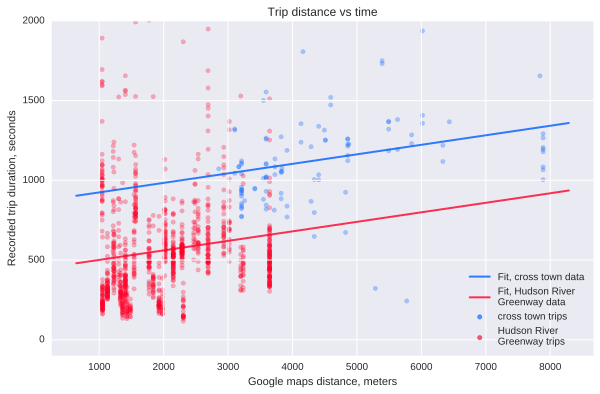

In [39]:
XX = np.arange(df['googledistance'].min() - 400,
               df['googledistance'].max() + 400)

ctXX = pd.DataFrame({'googledistance':XX,
                     'crosstown':np.ones(XX.shape)})

wsXX = pd.DataFrame({'googledistance':XX,
                     'crosstown':np.zeros(XX.shape)})

scatter_kwargs = {"zorder":0, 'alpha':0.3}
line_kwargs = {"zorder":100, 'alpha':0.8, 'lw':2}

a=6
gr=(1+np.sqrt(5))/2
plt.figure(figsize=[a*gr,a])
plt.autoscale(tight=True)
plt.xlabel('Google maps distance, meters')
plt.ylabel('Recorded trip duration, seconds')
plt.title("Trip distance vs time")
colorlist=plt.cm.gist_rainbow(np.linspace(0,2.8/4,4)).tolist()
colorlist.reverse()
cross_trips = df[df['crosstown'] == True]
plt.scatter(cross_trips['googledistance'],
            cross_trips['tripduration'],
            label='cross town trips', color=colorlist[0],
            **scatter_kwargs)
wests_trips = df[df['crosstown'] == False]
plt.scatter(wests_trips['googledistance'],
            wests_trips['tripduration'],
            label='Hudson River\nGreenway trips',
            color=colorlist[-1], **scatter_kwargs)
plt.plot(XX, simple_results.predict(ctXX), color=colorlist[0],
         label='Fit, cross town data', **line_kwargs)
plt.plot(XX, simple_results.predict(wsXX), color=colorlist[-1],
         label='Fit, Hudson River\nGreenway data',
         **line_kwargs)
plt.ylim(-100, 2000)
#plt.plot(gm_ctXX['distance'], google_results.predict(gm_ctXX), color='r', alpha=0.8, label='Google maps prediction, cross town trips')
plt.legend(loc='lower right')
plt.savefig('trip_distance_vs_time_actual.pdf')
plt.show()